<a href="https://colab.research.google.com/github/subodh2708/deep-learning---tensorflow-2.0/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning in tensorflow part 3: Scaling up(Food vision Mini)

In [1]:
!nvidia-smi

Sun Aug 28 12:30:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-28 12:30:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-28 12:30:53 (122 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback,unzip_data,plot_loss_curves,compare_historys,walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

--2022-08-28 12:30:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   219MB/s    in 7.2s    

2022-08-28 12:31:03 (216 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)

test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode= "categorical",
                                                               image_size = IMG_SIZE,
                                                               shuffle = "False")

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        monitor='val_accuracy',
                                                        save_weights_only= True,
                                                        save_best_only = True)

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
],name='data_augmentation')

In [10]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

input = layers.Input(shape=(224,224,3),name= "input_layers")
x = data_augmentation(input)
x= base_model(x,training= False)
x= layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation= 'softmax',name='output_layer')(x)
model = tf.keras.Model(input,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [13]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history_all_classes_10_percent= model.fit(train_data_all_10_percent,
                                          epochs= 5,
                                          steps_per_epoch = len(train_data_all_10_percent),
                                          validation_data = test_data,
                                          validation_steps= int(0.15* len(test_data)),
                                          callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 91s 313ms/step - loss: 3.4841 - accuracy: 0.2463 - val_loss: 2.4281 - val_accuracy: 0.4566
Epoch 2/5
237/237 [==============================] - 54s 228ms/step - loss: 2.3765 - accuracy: 0.4565 - val_loss: 2.0007 - val_accuracy: 0.5185
Epoch 3/5
237/237 [==============================] - 51s 216ms/step - loss: 2.0032 - accuracy: 0.5258 - val_loss: 1.8257 - val_accuracy: 0.5448
Epoch 4/5
237/237 [==============================] - 49s 207ms/step - loss: 1.7957 - accuracy: 0.5648 - val_loss: 1.7475 - val_accuracy: 0.5514
Epoch 5/5
237/237 [==============================] - 47s 196ms/step - loss: 1.6471 - accuracy: 0.5989 - val_loss: 1.6988 - val_accuracy: 0.5561


In [14]:
fine_tuning_results = model.evaluate(test_data)


790/790 [==============================] - 56s 70ms/step - loss: 1.7148 - accuracy: 0.5554


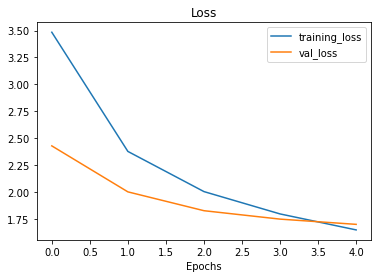

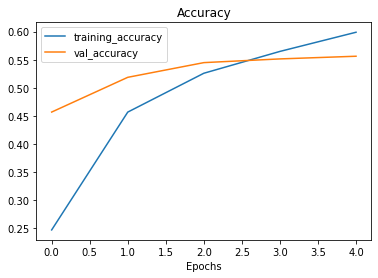

In [15]:
plot_loss_curves(history_all_classes_10_percent)